# Nested samping using Galilean Monte Carlo

This example demonstrates how to use Galilean Monte Carlo sampling [1] to sample from the posterior distribution for a logistic model fitted to model-simulated data. For a tutorial on nested sampling, see: [INSERT LINK to NESTED SAMPLING TUTORIAL NOTEBOOK].

[1] "Exploring Multi-Modal Distributions with Nested Sampling", 2013, Farhan Feroz and John Skilling.

First create fake data.

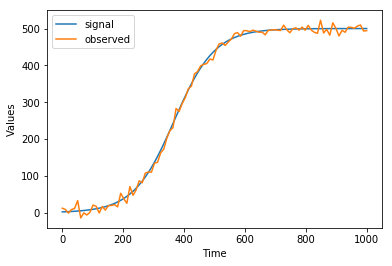

In [1]:
import os
os.chdir('/Users/appleuser/Desktop/AllPints/pints/')
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
r = 0.015
k = 500
real_parameters = [r, k]
times = np.linspace(0, 1000, 100)
signal_values = model.simulate(real_parameters, times)

# Add independent Gaussian noise
sigma = 10
observed_values = signal_values + pints.noise.independent(sigma, signal_values.shape)

# Plot
plt.plot(times,signal_values,label = 'signal')
plt.plot(times,observed_values,label = 'observed')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

Create the nested sampler that will be used to sample from the posterior.

In [2]:
# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, observed_values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, sigma * 0.5],
    [0.02, 600, sigma * 1.5])

# Create a nested ellipsoidal rejectection sampler
sampler = pints.GalileanMC(log_likelihood, log_prior)

# Set number of iterations
sampler.set_iterations(30000)

# Set the number of posterior samples to generate
sampler.set_posterior_samples(400)

# Set the number of active points
sampler.set_active_points_rate(1000)

# Set velocity proposal distribution
sampler.set_random_propose(False, mu=[0,0,0], sigma=[[0.005,0,0],[0,10,0],[0,0,0.1]])

Run the sampler!

In [3]:
samples, marginal_log_likelihood = sampler.run()
print('Done!')

Running Galilean Monte Carlo sampling
Number of active points: 1000
Total number of iterations: 30000
Total number of posterior samples: 400
Iter. Eval.  Time m:s
0     1        0:00.0
0     2        0:00.0
0     3        0:00.0
0     4        0:00.0
0     5        0:00.0
0     21       0:00.0
0     41       0:00.0
0     61       0:00.0
0     81       0:00.0
0     101      0:00.1
0     121      0:00.1
0     141      0:00.1
0     161      0:00.1
0     181      0:00.1
0     201      0:00.1
0     221      0:00.1
0     241      0:00.1
0     261      0:00.1
0     281      0:00.1
0     301      0:00.1
0     321      0:00.2
0     341      0:00.2
0     361      0:00.2
0     381      0:00.2
0     401      0:00.2
0     421      0:00.2
0     441      0:00.2
0     461      0:00.2
0     481      0:00.2
0     501      0:00.2
0     521      0:00.2
0     541      0:00.2
0     561      0:00.2
0     581      0:00.2
0     601      0:00.2
0     621      0:00.2
0     641      0:00.3
0     661      0:00.3
0

pints/toy/_logistic_model.py:64: RuntimeWarning: overflow encountered in exp
  exp = np.exp(-r * times)
pints/toy/_logistic_model.py:67: RuntimeWarning: overflow encountered in multiply
  values = k / (1 + c * exp)
pints/_nested/_galilean_mc.py:203: RuntimeWarning: overflow encountered in exp
  vP = np.exp(m_samples_all[:, d] - log_Z) * w
pints/_nested/_galilean_mc.py:203: RuntimeWarning: invalid value encountered in multiply
  vP = np.exp(m_samples_all[:, d] - log_Z) * w
pints/_nested/_galilean_mc.py:207: RuntimeWarning: invalid value encountered in less
  self._posterior_samples, p=vP)


## Plot posterior samples versus true parameter values (dashed lines)

In [7]:
samples

array([[  1.00889340e-02,   4.16817603e+02,   5.83709788e+00],
       [  1.00889340e-02,   4.16817603e+02,   5.83709788e+00],
       [  1.00889340e-02,   4.16817603e+02,   5.83709788e+00],
       ..., 
       [  1.00889340e-02,   4.16817603e+02,   5.83709788e+00],
       [  1.00889340e-02,   4.16817603e+02,   5.83709788e+00],
       [  1.00889340e-02,   4.16817603e+02,   5.83709788e+00]])

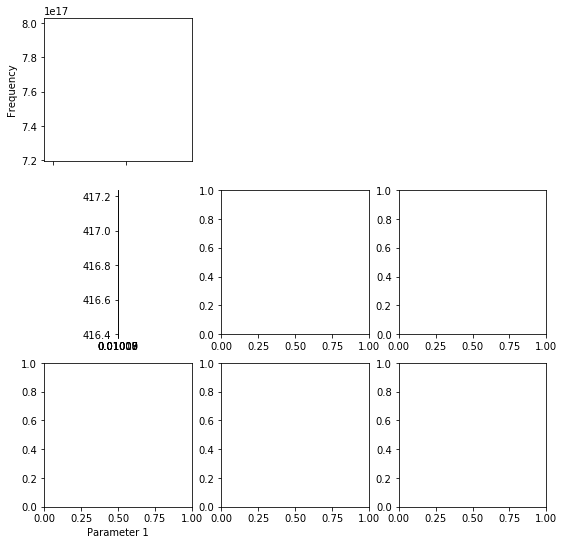

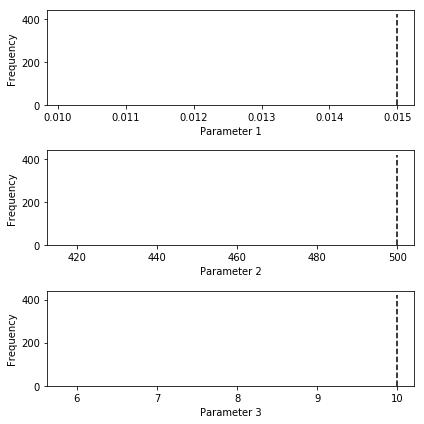

In [8]:
# Plot output
import pints.plot

pints.plot.histogram([samples], ref_parameters=[r, k, sigma])

plt.show()

In [6]:
vTheta = samples[0]
pints.plot.pairwise(samples, kde=True)

plt.show()

/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:2918: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0100889339805, right=0.0100889339805
  'left=%s, right=%s') % (left, right))
/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:817: RuntimeWarning: divide by zero encountered in true_divide
  return n/db/n.sum(), bins
/anaconda2/lib/python2.7/site-packages/numpy/lib/function_base.py:817: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bins
/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3239: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=416.817603419, top=416.817603419
  'bottom=%s, top=%s') % (bottom, top))


LinAlgError: singular matrix

## Plot posterior predictive simulations versus the observed data

In [ ]:
pints.plot.series(samples[:100], problem)
plt.show()

## Marginal likelihood estimate

In [9]:
print('marginal log-likelihood = ' + str(marginal_log_likelihood))

marginal log-likelihood = -24978.2034132


In [ ]:
log_likelihood([1,2,3])

In [ ]:
from scipy import integrate
f = lambda z, y, x: x*y*z
integrate.tplquad(f, 1, 2, lambda x: 2, lambda x: 3,lambda x, y: 0, lambda x, y: 1)

In [ ]:
f = lambda z, y, x: log_likelihood([x, y, z])

In [ ]:
integrate.tplquad(f, 0, 0.03, lambda x: 400, lambda x: 600,lambda x, y: 0, lambda x, y: 20)

In [ ]:
np.concatenate(np.array([1,2]),np.array([3]))

In [ ]:
1:2